# Xpand IT DS Challenge

## Configuration

### Hyperparameters

In [1]:
hparams = {
    # Seed number for random state
    "rnd_seed": 42,
    # Number of previous weeks whose data is to considered for prediction of current
    # week 
    "N_weeks_series": 8, 
    # Split fraction of the original training data to consider for testing
    "frac_test": 0.2,
    # Split fraction of the original training data to consider for validation
    "frac_val": 0.2,
    # Maximum number of epochs
    "N_epochs_max": 200,
    # Training mini-batch size
    "batch_size": 20,
    # Minimum change in the monitored validation metric to qualify as an improvement
    "min_delta": 1e-2,
    # Number of epochs with no improvement of the validation metric after which training
    # will be stopped
    "patience": 100,
}

### Import Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import plotly.graph_objects as go

### Configure pyplot and seaborn

In [3]:
# If set, put axes ticks and the gridlines below the plots
plt.rc("axes", axisbelow=True)

# [NOTE: seaborn uses matplotlib's rc (runtime configuration) and, therefore, there is
# no need to configure Seaborn's rc in particular.]

### Set random seed (for the sake of reproducibility)

In [4]:
# Set seed number to NumPy and pandas
# [NOTE: pandas use NumPy for random number generation.]
np.random.seed(hparams["rnd_seed"])

# Set the global seed number for TensorFlow
tf.random.set_seed(hparams["rnd_seed"])

### Define a DataFrame Styling Function

In [5]:
def style_df(df, caption=""):
    return (df.style
        .set_caption(caption)
        .set_table_styles([
            {
                "selector": "caption",
                "props": [
                    ("width", "100%"),
                    ("font-size", "16px"),
                    ("font-weight", "bold"),
                    ("font-style", "italic"),
                    ("text-align", "left"),
                    ("padding-top", "15pt"),
                    ("padding-bottom", "5pt"),
                    ("padding-left", "15pt"),
                ]
            },
            {
                "selector": "td",
                "props": [
                    ("padding-bottom", "10pt"),
                    ] 
            }
        ])
    )

## Business Analysis

### What is the Dow Jones Index?
The Dow Jones Index, also called **Dow Jones Industrial Average**, is a stock market index that rates the combination of $30$ prominent companies of the United States of America. It is based on the values of the stock shares of each of these $30$ companies. Its computation formula corresponds to

$$
\mathrm{DJIA} = \frac{\sum_{i} p_i}{d}\text{ ,}
$$

where $p_i$ is the price of a single stock share of the $i$-th company and $d$ is the so-called **Dow Divisor**. This divisor is adjusted in case of stock splits, spinoffs or similar structural changes. On [$26^{\mathrm{th}}$ of February of $2024$](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average#Computation), its value corresponded to $0.15221633137872$.

The list of $30$ companies accounted by the index may actually change as these cease to be prominent, underperforming when compared to those companies "below" them. As of February of $26^{\mathrm{th}}$ of February of $2024$, the list has changed $58$ times. To ensure that the Dow Jones Index remains continuous in face of such change the Dow Divisor $d$ is updated accordingly.

### How does the issued data compares with the Dow Jones Index?

The issued data does not correspond to the Dow Jones Index, but contains all the necessary data for computing it except the Dow Divisor (although out-of-the-scope for this project, and no table has been found, the present author believes that a more thorough search could be successful in retrieving Dow Divisor's historic values). The data is comprised by the stock share values of the $30$ prominent companies at the different weeks of the first two quarters of $2011$, plus some additional and useful info, such as **volume of exchanged  shares**, and **dividend yields**. 

* The **volume of exchanged shares** may describe the liquidity of the market (high values would make buying or selling shares to not significantly affect the stock's price), the stock price "momentum" (spikes in exchanged volume might start new trends) as well as the investor "sentiment" (high values indicate high interest and confidence in the stock);

* Companies may pay at certain times an amount to a shareholder based on the amount of shares held and a stipulated factor: the **dividend yield**. This corresponds to the ratio between the value of the dividend payment per stock share and the value of that same stock share. High values are usually associated with a high profitability and management confidence of the company, promoting further reinvestment by the shareholders, which could then increase the stock value.

[***NOTE:*** if the so-called ex-dividend dates were issued together with the data, one could have actually considered the dividend return to be part of the profit of the investor in the current problem. Since they were not, the computed profit was solely based on the relative change of the stock prices.]

All of these data are important for building a model that could reliably predict the evolution of the stock prices.

### The business problem

A client is to buy stock at the start of each week, immediately selling it at its end. The problem would be to know which stock to buy in each week so that maximum profit is obtained from their sale.


## Data Understanding

### Import the data

In [6]:
data = pd.read_csv("data/dow_jones_index.data")
display(style_df(df=data.head(), caption="Raw data"))

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.792670,nan,nan,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.428490,1.380223,239655616.000000,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.470660,-43.024959,242963398.000000,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.638310,9.355500,138428495.000000,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.933250,1.987452,151379173.000000,$17.33,$17.37,0.230814,97,0.175029


In [7]:
# ---> Get list of stocks

stocks = data["stock"].unique()

### Understand, transform, create and drop data

* **Column `quarter`:** 

    * It has the year quarter numbers (either $1$ or $2$) in the respective weeks. The data solely has two values for this quantity and it should not be used for later quarters as extrapolation would occur. In fact, although not shown, for the case of the current two quarters a model using such feature was constructed, and performed significantly worse;

    * **The column is to be dropped.**

In [8]:
# Drop column "quarter"
data = data.drop(columns="quarter")

* **Column `stock`:**
    * It has the acronyms that identify stock's company.

    * **It is also a <ins>data identifier</ins>.**

* **Column `date`:** 

    * It has the dates for the closing of the stock exchange in the respective weeks. **One should not directly use dates as features since they comprise a very large number of categories, whose some part may be "seen" during training but not during testing, inducing overfitting. For instance, by training with the data of the first quarter and testing with the data of the second, if the dates are used as features, the training cases would be supported but the testing ones not at all and extrapolation would occur.** However, if elements of the dates are seen in both batches (usually cyclic elements, such as the weekday, month, etc.) these could be used as features in place of the dates. In the current problem, the range of dates would not allow a proper usage of the common date cyclic elements. **Still, one could think of using an "artificial" cycling element, such as the ratio between the day number and the total number days of the month. For instance, the $8^{\mathrm{th}}$ day of a 31 days month would be associated with a ratio $8/31 \times 100 \,\%\approx 25.8\%$. Let `percent_month` be the resultant new column;**

    * To use the date as a simpler data identifier, one could tranform it into year's week number. Let the new column be `week_num`;

    * **New column `week_num` is to be used together with column `stock` as <ins>data identifier</ins>.**

    * **New column `percent_month` is to be used as <ins>feature</ins>.**

In [9]:
# Tranform column "date" into pandas Timestamp
data["date"] = pd.to_datetime(data["date"], format="%m/%d/%Y")

# Add column with percentage of the month associated with the dates
data["percent_month"] = (data["date"].dt.day /
    data["date"].dt.strftime(date_format="%m/%d/%Y").apply(
        lambda x: pd.Period(x).days_in_month
    ) * 100
)

# Add column with year's week numbers associated with the dates
data["week_num"] = data["date"].dt.isocalendar().week.astype(int)

# Drop column "date"
data = data.drop(columns="date")

* **Columns `open`, `high`, `low`, `close` and `percent_change_price`:**

    * The first four have the value per share of the stocks at the opening, best day, worse day and closing of the market at that week, respectively. They are formatted as strings and prefixed by the american dollar "$\$$". **To properly handle them, they should be converted to floats;**

    * Also, since column `percent_change_price` (relative difference (in percentage) between closing and opening values) are simply obtained from  `open` and `close` one of the columns would be redundant;

    * **Column `close` is to be dropped;**

    * **Columns `open`, `high`, `low` and `percent_change_price` are to be used as <ins>features</ins>.**

In [10]:
# Drop column "next_weeks_close"
data = data.drop(columns="close")

# Re-format columns "open", "high" and "low", to disregard the dollar sign
for col in ["open", "high", "low"]:
    data[col] = data[col].apply(lambda x: float(x.removeprefix("$")))

* **Columns `volume`, `percent_change_volume_over_last_wk` and `previous_weeks_volume`:**

    * Since `percent_change_volume_over_last_wk` (relative difference (in percentage) of exchanged volume of stock shares between current and previous week) are obtained from `previous_weeks_volume` and `volume`, one should disregard one of the columns. Arbitrarily, it was decided for `previous_weeks_volume` to be that one;

    * Furthermore, since multiple previous weeks besides the current one are to be used as feature data for the prediction of the following week, one could at first guess disregard the columns `volume` of the previous weeks, since they may be computed from the column `volume` of the current week together with the columns `percent_change_volume_over_last_wk` of the current and previous weeks, making them redundant. However the employed model (a Long Short-Term Memory (LSTM)) requires all weeks to have the same feature components, and because of that, `volume` was simply regarded.

    * **Column `previous_weeks_volume` is to be dropped;**

    * **Column `percent_change_volume_over_last_wk` is to be used as <ins>feature</ins>;**

    * **Column `volume` is to be used as <ins>feature</ins>.**

In [11]:
# Drop column "next_weeks_close"
data = data.drop(columns="previous_weeks_volume")

* **Columns `next_weeks_open`, `next_weeks_close` and `percent_change_next_weeks_price`:**

    * Since `percent_change_next_weeks_price` (relative difference (in percentage) between closing and opening stock values of the future week) are obtained from `next_weeks_open` and `next_weeks_close`, one of them should to be dropped;

    * Also, since multiple previous weeks besides the current one are to be used as feature data for the prediction of the following week, one could think of disregarding the columns `next_weeks_open` of the previous weeks, since they coincide with the columns `open` of the following contiguous ones making them redundant. However, this should not be done, since due to the constrains of the LSTM model, all weeks need to have the same feature components.

    * Note that the values of the columns `next_weeks_open` and `next_weeks_close` are formatted as strings and prefixed by the american dollar "$\$$". They should be re-formatted as floats.

    * **Column `next_weeks_close` is to be dropped;**

    * **Column `next_weeks_open` is to be used as <ins>feature</ins>;**

    * **Column `percent_change_next_weeks_price` is to be used as <ins>target</ins>.**

In [12]:
# Drop column "next_weeks_close"
data = data.drop(columns="next_weeks_close")

# Re-format column "next_weeks_open" to disregard the dollar sign
data["next_weeks_open"] = data["next_weeks_open"].apply(
    lambda x: float(x.removeprefix("$"))
)

* **Columns `days_to_next_dividend` and `percent_return_next_dividend`:**

    *  The former is the number of days from current week to the day of the next dividend payment. The latter is the ratio (in percentage) between the value of the dividend payment per stock share and the value of that same stock share, based on the state of the current week;
    
    * **The columns are to be used as <ins>features</ins>.**

### What is the Target?

The model should predict the relative change in stock price of the current week - **hence, the usage of column `percent_change_next_weeks_price` as target**. However, note that here the frame of reference of the investor and not the one of the data records is used to define "current week": "current week" is what in the data corresponds to the "following week" in each week record. In this view, the previous week would actually correspond to data's "current week", described by column `week_num`.

The solution of the current problem would not directly be the prediction of `percent_change_next_weeks_price` but, indirectly, the stock whose such quantity is maximum - which may be easily computed from the former.

In [13]:
# Column name of data's previous week record, defining current week's target
col_y = "percent_change_next_weeks_price"

### What are the Features?

The prediction capabilities of the model could be improved by using the history data before and at the beginning of the current week as features. In the client frame of reference, the history feature data of the current and previous weeks to be used for that week is

* `percent_month`;
* `open`;
* `high`;
* `low`;
* `percent_change_price`;
* `volume`;
* `percent_change_volume_over_last_wk`;
* `next_weeks_open`;
* `days_to_next_dividend`;
* `percent_return_next_dividend`.

All of these are in data's records of previous week and those before.


In [14]:
# Column names of data's previous week records, defining current week's features
cols_x = [
    "percent_month", "open", "high", "low", "percent_change_price", "volume",
    "percent_change_volume_over_last_wk", "next_weeks_open", "days_to_next_dividend",
    "percent_return_next_dividend"
]

# Number of feature quantities
N_x = len(cols_x)

### Sort the data by stock and week number

Let better handle the data in the following steps, let one sort it by stock and week number.

In [15]:
data = data.sort_values(by=["stock", "week_num"], ascending=True)

### Display the new DataFrame

In [16]:
# ---> Display the new DataFrame

# Reorder DataFrame's columns
data = data[[
    "stock", "week_num", "percent_month", "open", "high", "low",
    "percent_change_price",	"volume", "percent_change_volume_over_last_wk",
    "next_weeks_open", "days_to_next_dividend", "percent_return_next_dividend",
    "percent_change_next_weeks_price"
]]

display(style_df(df=data.head(), caption="Raw data"))

,stock,week_num,percent_month,open,high,low,percent_change_price,volume,percent_change_volume_over_last_wk,next_weeks_open,days_to_next_dividend,percent_return_next_dividend,percent_change_next_weeks_price
0,AA,1,22.580645,15.820000,16.720000,15.780000,3.792670,239655616,nan,16.710000,26,0.182704,-4.428490
1,AA,2,45.161290,16.710000,16.710000,15.640000,-4.428490,242963398,1.380223,16.190000,19,0.187852,-2.470660
2,AA,3,67.741935,16.190000,16.380000,15.600000,-2.470660,138428495,-43.024959,15.870000,12,0.189994,1.638310
3,AA,4,90.322581,15.870000,16.630000,15.820000,1.638310,151379173,9.355500,16.180000,5,0.185989,5.933250
4,AA,5,14.285714,16.180000,17.390000,16.180000,5.933250,154387761,1.987452,17.330000,97,0.175029,0.230814


### Exploratory data analysis

Let one start by visualizing the opening stock price curves of the different companies.

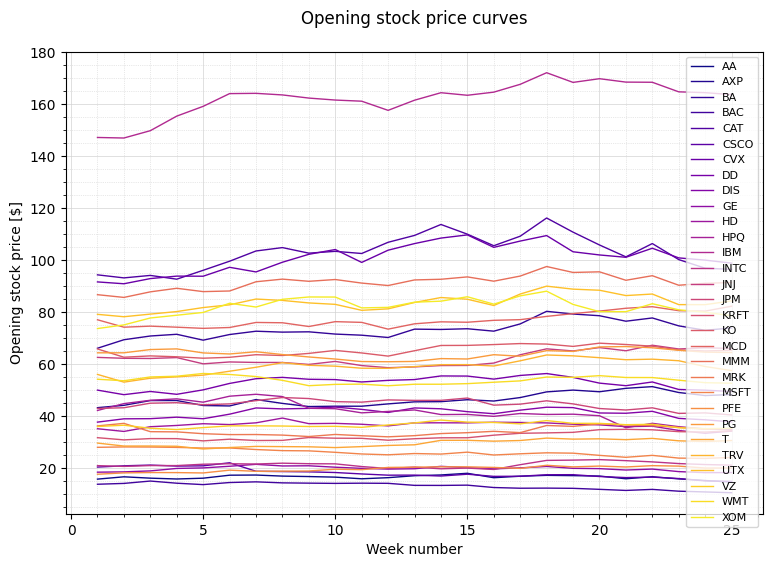

In [17]:
# ---> Plot

# Initialise figure and axes
plt.figure(figsize=(9, 6))
ax = plt.axes()
plt.title("Opening stock price curves", pad=20)

# Colormap
colormap = plt.colormaps["plasma"]

# Plot curves
for (i, stock) in enumerate(stocks):
    ax.plot(
        data[data["stock"] == stock]["week_num"],
        data[data["stock"] == stock]["open"],
        linestyle="solid",
        color=colormap(i/len(stocks)),
        alpha=1,
        linewidth=1,
        label=stock,
    )

# Define axes labels                                
ax.set_xlabel("Week number", fontdict={"fontsize": 10})
ax.set_ylabel("Opening stock price [\$]", fontdict={"fontsize": 10})

# Enable axes' minor ticks
ax.minorticks_on()

# Define grid
ax.grid(
    visible=True,
    which="major",
    color="lightgray",
    linestyle="solid",
    linewidth=0.5
)
ax.grid(
    visible=True,
    which="minor",
    color="lightgray",
    linestyle="dotted",
    linewidth=0.5
)

# Legend
ax.legend(fontsize=8)

# Show plot
plt.show() 

Some of the stock prices may vary a lot in time. In fact, for a much larger amount of time (in the order of the years), one tipically observes increasing curves with a lot of "spikes".

Let one now plot the value distribution of the different columns.

In [18]:
# ---> Define custom histogram plotting function

def hisplot_custom(
    df,
    col,
    # Data type to which the column is to be transformed
    col_dtype=float,
    stat="count",
    bins=20,
    shrink=1.0,
    bar_label=True,
    bar_label_rotation=0,
    xticklabels_rotation=0,
):
    
    # Initialise figure and axes
    plt.figure(figsize=(9, 6))
    ax = plt.axes()
    plt.title(
        "Occurrence" + 
        (" fractions " if stat == "percent" else " counts ") +
        "per value" +
        (" range " if stat == "percent" else " ") + f"in column \"{col}\"",
        pad=20
    )


    # Define bar plot
    sns.histplot(
        ax=ax,
        data=df.astype({col: col_dtype}),
        x=col,
        stat=stat,
        bins=bins,
        shrink=shrink,
        edgecolor="black",
        alpha=1,
        color="blue",
        linewidth=1.0,
    )

    if bar_label == True:
        # Plot bars' values
        for container in ax.containers:
            ax.bar_label(
                container=container,
                padding=2,
                fmt=r"${:.2f}\,\%$" if stat == "percent" else r"${:.0f}$",
                size=9,
                rotation=bar_label_rotation
            )

    if col_dtype != str:
        # Plot mean vertical line
        ax.axvline(
            df[col].mean(),
            color="black",
            linestyle="dashed",
            linewidth=1,
            label=(f"Mean: ${df[col].mean():.2f}$"),
        )

        # Plot median vertical line
        ax.axvline(
            df[col].median(),
            color="black",
            linestyle="dotted",
            linewidth=1,
            label=(f"Median: ${df[col].median():.2f}$"),
        )

        # Create empty plot just to add the standard deviation value to legend
        ax.plot([], [], alpha=0, label=f"Std Dev: ${df[col].std():.2f}$")


    # Define axes labels                                
    ax.set_xlabel(col, fontdict={"fontsize": 10})
    ax.set_ylabel(
        r"Fraction $[\%]$" if stat == "percent" else r"Count",
        fontdict={"fontsize": 10}
    )

    # Define axes ticks
    ax.tick_params(axis="x", rotation=xticklabels_rotation)

    # Define axes ranges
    ax.set_ylim(top=1.1 * ax.get_ylim()[1])

    # Enable axes' minor ticks
    ax.minorticks_on()

    # Define grid
    ax.grid(
        visible=True,
        which="major",
        color="lightgray",
        linestyle="solid",
        linewidth=0.5
    )
    ax.grid(
        visible=True,
        which="minor",
        color="lightgray",
        linestyle="dotted",
        linewidth=0.5
    )
    
    if col_dtype != str:
        # Legend
        ax.legend(fontsize=8)

    # Show plot
    plt.show() 

* ***Stocks***

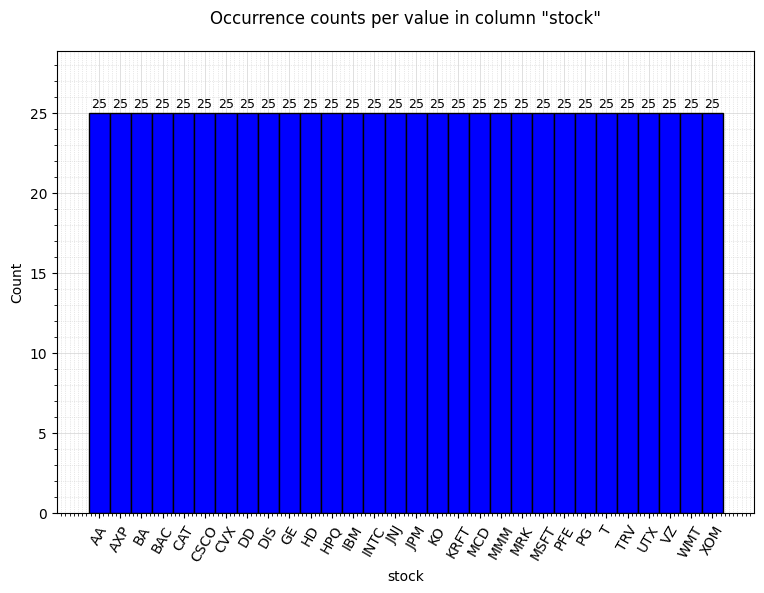

In [19]:
# ---> Plot

hisplot_custom(
    df=data,
    col="stock",
    col_dtype=str,
    stat="count",
    xticklabels_rotation=60
)

* ***Week numbers***

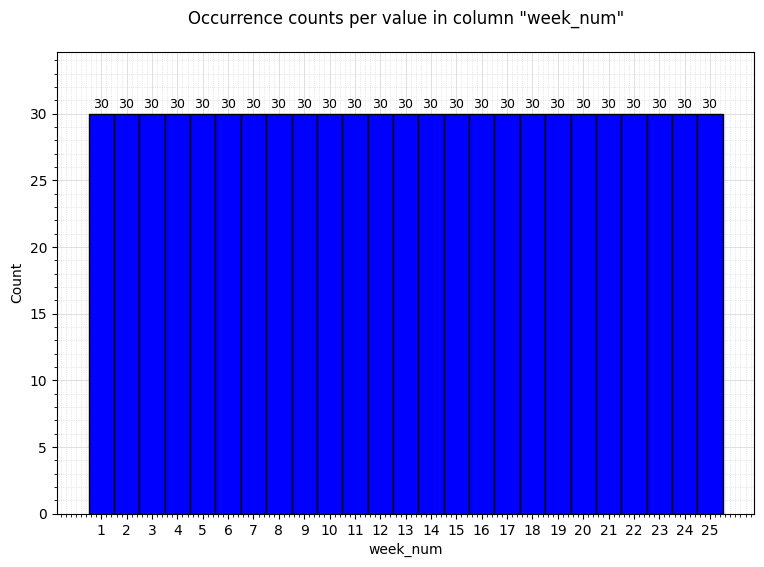

In [20]:
# ---> Plot

hisplot_custom(
    df=data,
    col="week_num",
    col_dtype=str,
    stat="count",
)

Since stocks and week numbers' counts are uniform, and a stock cannot be associated with the same week multiple times, one may conclude that **there are no missing records, that is, all stocks have records at all weeks**.

Also, there **25 weeks in total, and these are contiguous.**

* ***Opening, highest and lowest stock prices during the week***

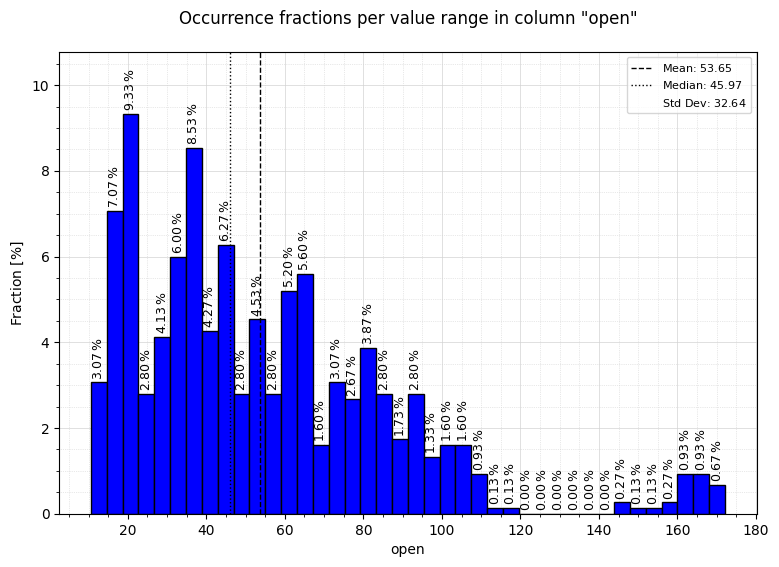

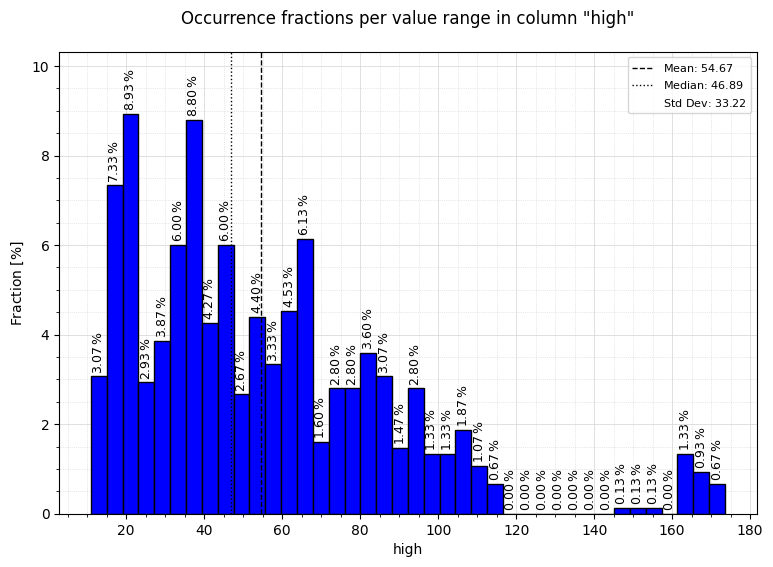

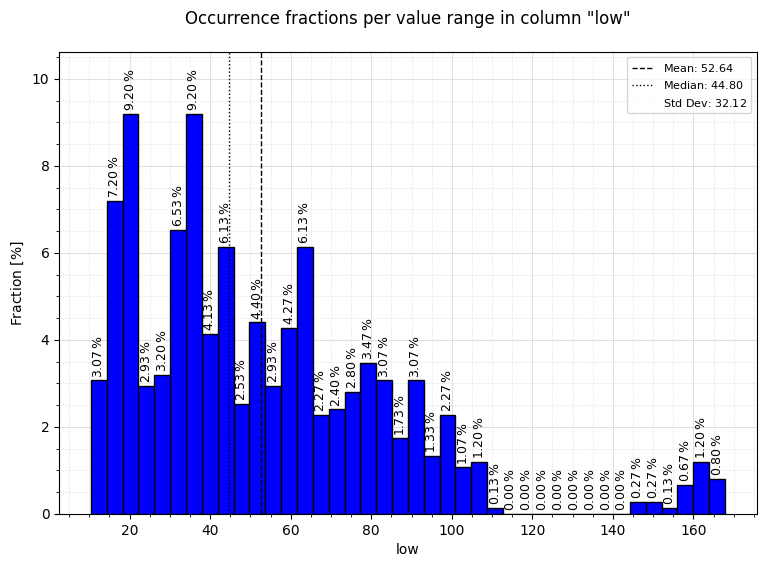

In [21]:
# ---> Plot

hisplot_custom(
    df=data,
    col="open",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

hisplot_custom(
    df=data,
    col="high",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

hisplot_custom(
    df=data,
    col="low",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The distributions of the opening, highest and lowest stock values during the week follow identical distributions though not any characteristic one. They have a long tail at the high value regime, with some significant occurrence counts at the very end.

* ***Relative change of stock price during the week***

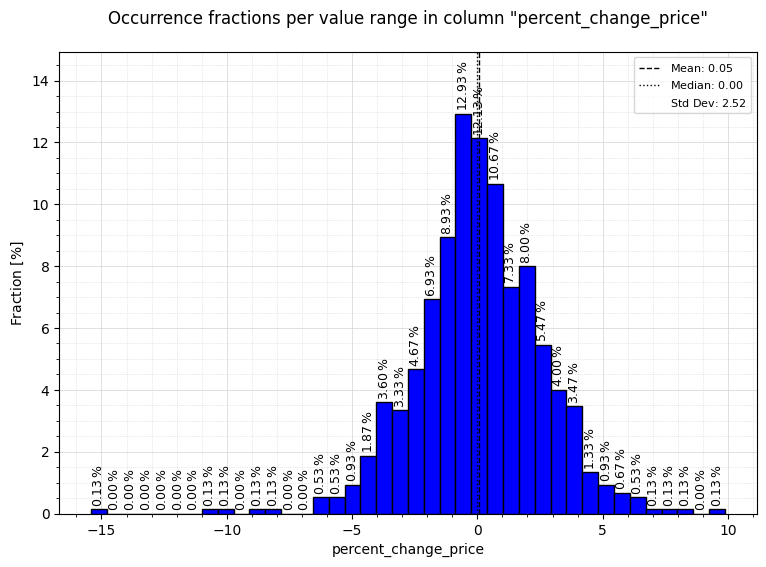

In [22]:
# ---> Plot

hisplot_custom(
    df=data,
    col="percent_change_price",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The relative changes of stock price during the week follows a quasi-normal distribution with mean around $0\,\%$ and with extreme values at around $-15$ and $10\,\%$. One may say that, **in average, the stock price does not significantly change during the week, but abrupt swings might happen - postive and negative - besides deviations with a standard value of $2.52\,\%$**.

* ***Volume***

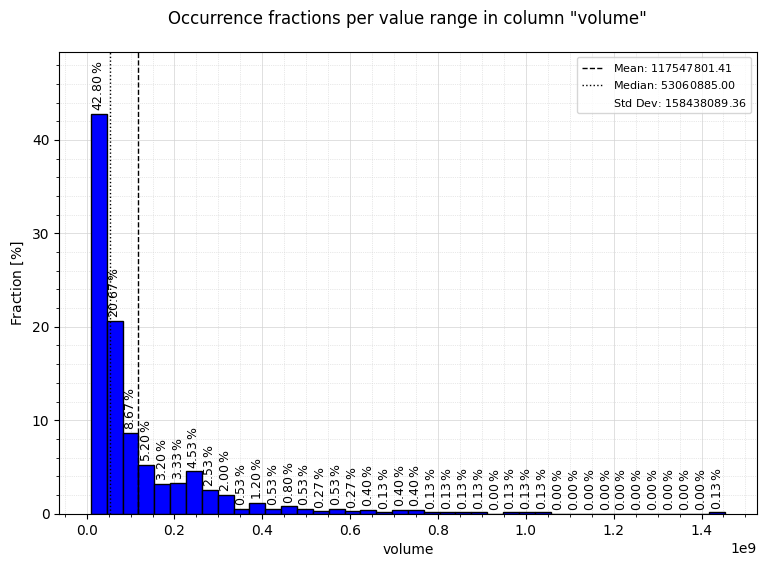

In [23]:
# ---> Plot

hisplot_custom(
    df=data,
    col="volume",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The volume of the current week has a highly skewed distribution, having a long tail at the high value regime. Its standard deviation is quite significant, being around $1.35$ times larger than its mean.

* ***Relative change of the exchanged volume at the from previous to current week***

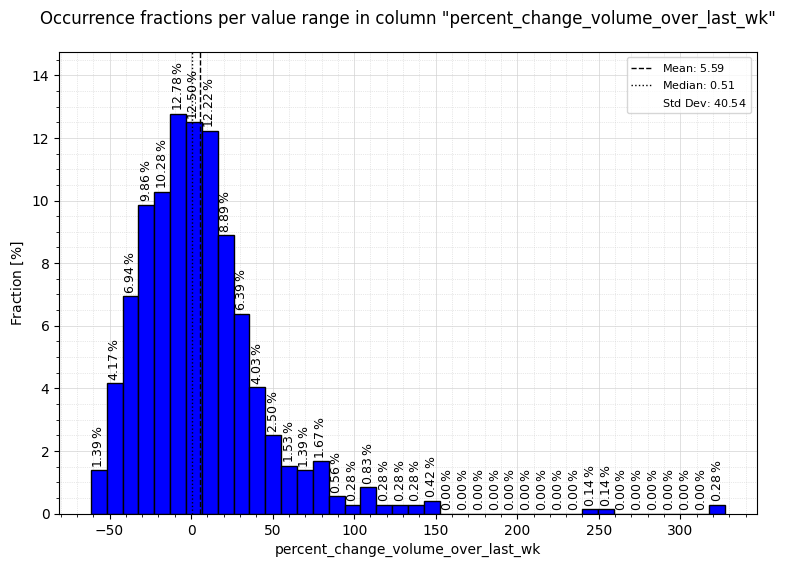

In [24]:
# ---> Plot

hisplot_custom(
    df=data,
    col="percent_change_volume_over_last_wk",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The relative change of the exchanged volume from previous to current week follows a distribution that may be compared to a normal one with a longer tail at thigh value regime. Note that the standard deviation is quite significant:  $40.54\,\%$, while the mean is solely $5.59\,\%$.

* ***Number of day to next dividend payment***

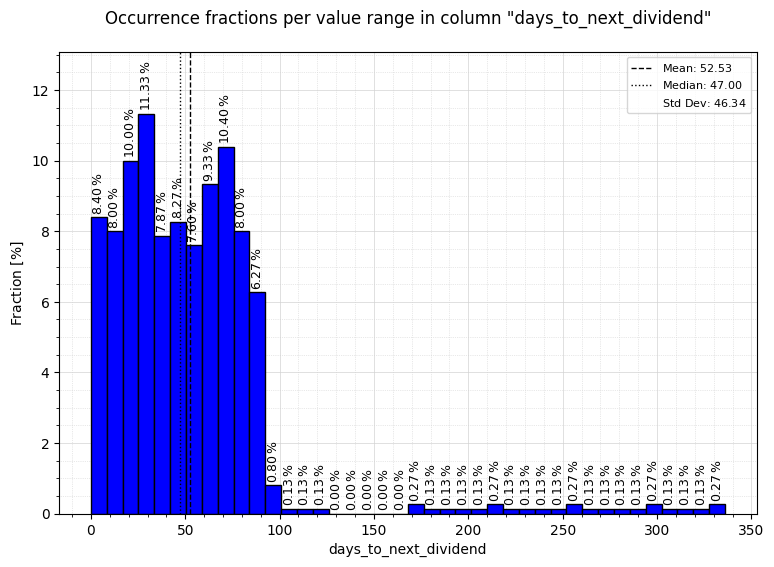

In [25]:
# ---> Plot

hisplot_custom(
    df=data,
    col="days_to_next_dividend",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The number of days from the current week to the next dividend payment follows a more-or-less uniform distribution between $0$ and $90$, and a tail of insignificant height between $100$ and $340$. One may then infer that most periods between dividend payments might correspond to year quarters, while just a few might extend to as much as a year. 

* ***Value of the following dividend yield***

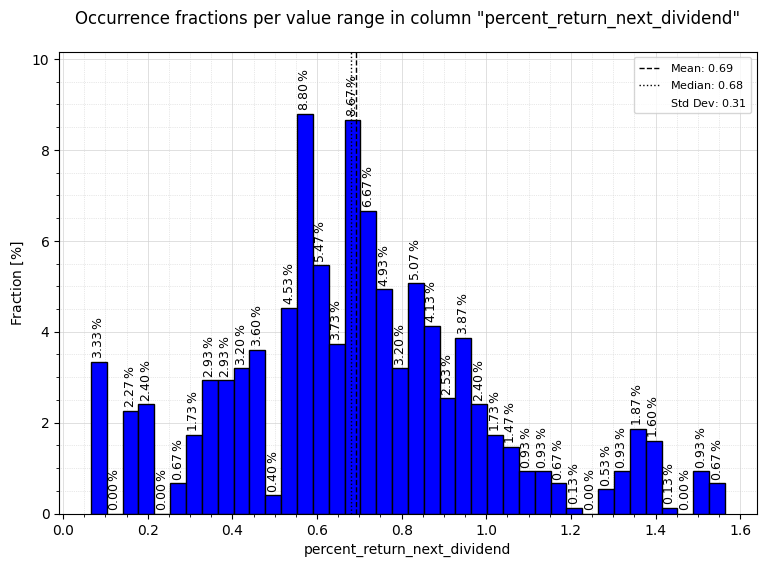

In [26]:
# ---> Plot

hisplot_custom(
    df=data,
    col="percent_return_next_dividend",
    col_dtype=float,
    stat="percent",
    bins=40,
    bar_label_rotation=90,
)

The following dividend yield has a non-characteristic distribution. It has a mean of $0.69\,\%$ and standard deviation of $0.31\,\%$. Its extremes are around $0.05$ and $1.55\,\%$.

###  Handling missing values

In [27]:
# ---> Get missing value counts

N_na = data.isna().sum()
display(style_df(df=N_na.to_frame(name="N_na"), caption="Counts of missing values per column"))

,N_na
stock,0
week_num,0
percent_month,0
open,0
high,0
low,0
percent_change_price,0
volume,0
percent_change_volume_over_last_wk,30
next_weeks_open,0


Solely column `percent_change_volume_over_last_wk` has missing values, and, coincidently, of number $30$, which is also the number of companies regarded by the Dow Jones index. One may already suspect that such missing values are associated with the first week, as this one might not have volume data associated with the past.

Let one display the unique week numbers associated with the missing values to assert this suspicion.

In [28]:
# ---> Get week numbers associated with the missing values

na_week_num_unique = data[data.isna().any(axis=1)]["week_num"].unique()
display(style_df(
    pd.DataFrame({"week_num": [na_week_num_unique]}),
    caption="Unique week numbers associated with the missing values"
))

,week_num
0,[1]


All of the dates associated with the missing values correspond to the first week of the first quarter, as suspected. As further shown in the [Exploratory data analysis section](#exploratory-data-analysis), the distribution of the values in the column `percent_change_volume_over_last_wk` is close to normal. It has a large standard deviation, though. To avoid biasness, it was decided to simply use the mean values associated with each stock to fill the respective missing values at the first week.

In [29]:
# ---> Fill missing values with respective stock-wise
# "percent_change_volume_over_last_wk" means

mean_percent_change_volume_over_last_wk = {stock:
    data[data["stock"]==stock]["percent_change_volume_over_last_wk"].mean()
    for stock in stocks
}

for stock in stocks:
    # [NOTE: an auxiliary copy needs to be created toa avoid SettingWithCopyWarning.]
    data_aux = data[data["stock"]==stock].copy()
    data_aux["percent_change_volume_over_last_wk"] = (
        data[data["stock"]==stock]["percent_change_volume_over_last_wk"].fillna(mean_percent_change_volume_over_last_wk[stock])
    )
    
    data[data["stock"]==stock] = data_aux

### Redefine data indices as the combination of stock and week number

In [30]:
data = data.set_index(["stock", "week_num"])

### Construct DataFrames of features and targets from the data

The number of previous weeks whose data is to be used for prediction of the current one is set in the very beginning of this notebook as a hyperparameter, `hparams["N_weeks_series"]`.

Note that by following this procedure, the model will not be able to predict the relative change of stock price of the first `hparams["N_weeks_series"]` weeks, since there is not sufficient available history for that.

Also note that in the constructed DataFrames, the respective index `week_num` should be associated with the number of the week whose change in stock price is to be predicted.

In [31]:
# ---> Function for extracting features and targets
def get_x_y(row):
    # Stock and week number of data's previous week record
    (stock, week_num) = row.name
    # Features of data's records of previous weeks
    # [NOTE: as required by Keras' LSTM model: first dimension associated with time
    # instant, second with feature component.]
    x = (
        data.loc[stock].loc[week_num - hparams["N_weeks_series"] + 1 : week_num]
        [cols_x]
    ).to_numpy()

    # Target of data's previous week record
    y = row[col_y]

    new_row = pd.Series([x, y], index=["x", "y"])

    return new_row

In [32]:
# Extract features and targets 
data = data.apply(get_x_y, axis="columns")

# Redefine index week_num as week_num + 1
data.index = pd.MultiIndex.from_arrays([
    data.index.get_level_values("stock"),
    data.index.get_level_values("week_num") + 1
])

# Drop non-supported weeks
data = data[data.index.get_level_values("week_num") >= hparams["N_weeks_series"] + 1]

# Display DataFrames
display(style_df(df=data.head(), caption="Features and targets"))

### Split data into training, validation and test one

To test the performance of the trained model on "unseen" future data, it was decided to split the original data into training, validation and test subsets, where the weeks regarded in the two last subsets are in the future from the training ones. The hyperparameters `hparams["frac_val"]` and `hparams["frac_test"]` as set in the very beginning of this notebook define the respective fractions of the original data to be used as validation and test ones.

Note that **early stopping** is to be considered while training to avoid getting an overfitting model, hence the consideration of a validation set.

In [33]:
# ---> Numbers
# Week numbers
week_nums = data.index.get_level_values("week_num").unique()
# Number of week numbers
N_week_num= len(week_nums)
# Number of validation week numbers
N_week_num_val = round(hparams["frac_val"] * N_week_num)
# Number of test week numbers
N_week_num_test = round(hparams["frac_test"] * N_week_num)

# Validation week numbers
week_nums_val = week_nums[- N_week_num_test - N_week_num_val : -N_week_num_test]
# Test week numbers
week_nums_test = week_nums[-N_week_num_test:]

# ---> Data split
# Validation subset
data_val = data[data.index.get_level_values("week_num").isin(week_nums_val)]
# Validation subset
data_test = data[data.index.get_level_values("week_num").isin(week_nums_test)]
# Training subset
data_train = data.drop(data_val.index).drop(data_test.index)

To properly use the data in the Keras model, one needs to transform the Series of features and targets to NumPy arrays.

In [34]:
x_train = np.array(data_train["x"].to_list())
y_train = np.array(data_train["y"].to_list())

x_val = np.array(data_val["x"].to_list())
y_val = np.array(data_val["y"].to_list())

x_test = np.array(data_test["x"].to_list())
y_test = np.array(data_test["y"].to_list())

## Modelling

### Define Keras model

One of the state-of-the-art ML models for predicting stock prices is the **Long Short-Term Memory (LSTM)** one. LSTMs are recurrent neural networks that have the ability to capture temporal patterns and dependencies in time-series data. This makes them ideal for tasks like stock price prediction, whose state does not only strongly depends on the present but also on the past.

Since the current problem is about regression, **the mean squared error (MSE) was chosen as loss and metric.** This is a "well-behaved" continuous function that highly penalises outliers - and for that reason, one of the most widely used regression loss functions.

To avoid having a model that overlooks (or underlooks) a feature when compared to others due to their dimensions, **one should standardize them**. This additionally would make the training more efficient and mitigate overflow (or underflow) numerical problems.

The architecture of the model is comprised by

* **a standardization layer** - whose mean and variance are computed using the training features;
* **2 LSTM layers** - to capture the temporal patterns and dependencies;
* **a dense layer with activation function** - to further non-linearly model the mid-outputs;
* **a dense layer with just 1 unit and without activation function** - since there is solely 1 target component, and it is a continuous variable.


In [35]:
# ---> Define model

# Standardization layer
norm = tf.keras.layers.Normalization(axis=-1)

# Compute mean and variance from the training features and update the respective
# parameters in the normalization layer
norm.adapt(x_train)

# Define an input layer
inputs = tf.keras.Input(shape=(hparams["N_weeks_series"], N_x))

# Define the input of the normalization layer as the output of the input layer
x = norm(inputs)

# Define all the other layers
# [NOTE: since there is solely one target component and this one is continuous, the last
# layer of the model needs to have only 1 unit and no activation function.]
x = tf.keras.layers.LSTM(
    units=20,
    activation="tanh",
    recurrent_activation="sigmoid",
    return_sequences=True,
    dropout=0.1
)(x)
x = tf.keras.layers.LSTM(
    units=10,
    activation="tanh",
    recurrent_activation="sigmoid",
    return_sequences=False
)(x)
x = tf.keras.layers.Dense(units=10, activation="relu")(x)
outputs = tf.keras.layers.Dense(units=1)(x)

# Create model from input layer and resultant output layer
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# ---> Model configuration
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
    ),
    loss="mse",
)

# ---> Visualise a summary on the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 8, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 8, 10)          │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 8, 20)          │         2,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         1,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,862 (15.09 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 21 (88.00 B)

### Define callback functions for training

In [36]:
# ---> Callback for ajusting learning rate
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    # Factor by which the learning rate is multiplied on reduction
    factor=0.5,
    # Minimum change in the monitored metric to qualify as an improvement
    min_delta=1e-1,
    # Number of epochs with no improvement of the metric after which learning rate will
    # be reduced
    patience=50,
    # Lower bound on the learning rate
    min_lr=1e-5,
    verbose=0,
)

In [37]:
# ---> Callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    # Metric whose early stopping is to be based on
    monitor="val_loss",
    min_delta=hparams["min_delta"],
    patience=hparams["patience"],
    # Number of epochs to wait before starting to monitor the metric
    start_from_epoch=0,
    verbose=1,
)

In [38]:
# ---> Callback for saving best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    # Filepath for which the model is to be saved
    filepath="model.keras",
    # Metric whose model checkpointing is to be based on
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=False,
    verbose=0,
)

### Train the model

In [39]:
fit_history = model.fit(
    # Training data
    x_train,
    y_train,
    # Validation data
    validation_data=(
        x_val,
        y_val,
    ),
    batch_size=hparams["batch_size"],
    epochs=hparams["N_epochs_max"],
    verbose=0,
    callbacks=[lr_reducer, checkpoint, early_stopping]
)

Epoch 160: early stopping


## Post-processing

### Loss curves

In [40]:
# ---> Get losses from fit history
fit_loss = pd.DataFrame(
    data = {
        key: fit_history.history[key]
        for key in ["loss", "val_loss"]
    },
    index = list(range(1, len(fit_history.history["loss"]) + 1))
).rename(columns={
    "loss": "train_loss"
})

In [41]:
# ---> Losses at lowest validation one
fit_loss_best = pd.DataFrame(
    data = {
        "epoch": fit_loss["val_loss"].idxmin(),
        **fit_loss.loc[fit_loss["val_loss"].idxmin()].to_dict()
    },
    index=[0]
)

In [42]:
# ---> Plot fitting curves
# Plotly GO (Graph Objects) figure
fig = go.Figure()

# Line plot of training losses
fig.add_trace(
    go.Scatter(
        x=fit_loss.index,
        y=fit_loss["train_loss"],
        name=r"Training",
        line=dict(color="blue", dash="solid", width=1.5),
        showlegend=True,
        mode="lines",
    )
)

# Line plot of validation losses
fig.add_trace(
    go.Scatter(
        x=fit_loss.index,
        y=fit_loss["val_loss"],
        name=r"Validation",
        line=dict(color="red", dash="solid", width=1.5),
        showlegend=True,
        mode="lines",
    )
)

# Line plot of best epoch
fig.add_trace(
    go.Scatter(
        x=[fit_loss_best.iloc[0]["epoch"], fit_loss_best.iloc[0]["epoch"]],
        y=[0, fit_loss_best.iloc[0]["val_loss"]],
        line=dict(dash="dot", color="rgba(0,0,0,1)", width=1),
        mode="lines",
        showlegend=False,
    )
)

# Marker plot of best epoch
fig.add_trace(
    go.Scatter(
        x=[fit_loss_best.iloc[0]["epoch"]],
        y=[fit_loss_best.iloc[0]["val_loss"]],
        marker=dict(
            symbol="circle",
            size=3,
            color="rgba(0,0,0,0)",
            line=dict(width=1.5, color="black"),
        ),
        mode="markers",
        name="Best epoch",
        showlegend=True,
    )
)

# Annotation
fig.add_annotation(
    x=fit_loss_best.iloc[0]["epoch"],
    y=fit_loss_best.iloc[0]["val_loss"],
    text=f"({fit_loss_best.iloc[0]['epoch']:.0f}, {fit_loss_best.iloc[0]['val_loss']:.2f})",
    showarrow=False,
    arrowhead=1,
    xanchor="center",
    yanchor="bottom",
    yshift=15,
)

fig.update_layout(
    # Figure dimensions
    width=800,
    height=600,
    
    # Template
    template="plotly_white",
    
    # Font family
    font_family="Arial",
    
    # Title
    title=dict(
        text="<b><i>Loss curves</i></b>",
        font=dict(size=16),
        pad=dict(t=15, b=5, l=15),
    ),
    
    # Axes titles
    xaxis_title=dict(text="Epoch", font=dict(size=12)),
    yaxis_title=dict(text="Loss (MSE)", font=dict(size=12)),
    
    # Axes
    xaxis=dict(
        showline=True,
        linecolor="black",
        linewidth=1,
        mirror=True,
        ticks="outside",
        range=[1, None],
    ),

    yaxis=dict(
        showline=True,
        linecolor="black",
        linewidth=1,
        mirror=True,
        ticks="outside",
        range=[0, None],
    ),

    # Legend
    legend=dict(
        title=dict(text="<b>Legend</b>", font=dict(size=12)),
        font=dict(size=10),
        bordercolor="rgba(255,255,255,0.9)",
        borderwidth=0,
        bgcolor="rgba(255,255,255,0.9)"
    ),
)

# Show plot
fig.show()

The losses associated with the training and validation datasets seem to decrease together in the beginning, but after some epoch they depart and the model significantly overfits the training data.

### Losses obtained in the three subsets at best validation epoch

In [43]:
# Load best model
model = tf.keras.models.load_model("model.keras")

# Get test score
loss_test = model.evaluate(x_test, y_test, verbose=0)

fit_loss_best = pd.DataFrame({**fit_loss_best, "test_loss": loss_test})

# Display scores
display(style_df(df=fit_loss_best, caption=f"Training, validation and test losses"))

,epoch,train_loss,val_loss,test_loss
0,60,3.658195,4.847594,7.735657


At best validation epoch, the test loss is even higher than the validation one which suggests that future events get to be more and more difficult to predict as the weeks depart from the training (also earlier) ones.

**One may then conclude that more features (and hopefully, that are also more meaningful) should be taken into consideration to properly modely the stock price trends. Although not shown here, several numbers of previous weeks in the time series used for prediction were tried besides the one herein presented (8). Higher values (e.g. 10) were successful in getting a significantly higher performance in the training and validation domains but not at all in the test domain - in fact, the respective losses increased in that case. This shows that the flaws of the current modelling approach mostly resides on the lack of meaning features in the issued data for future events.**

### Predicted curves for week's relative change of some stock prices

In [44]:
# Turn SettingWithCopyWarning off due to false positive
pd.options.mode.chained_assignment = None

# Add predictions to respective DataFrames
data_train["y_pred"] = model.predict(x_train, verbose=0).flatten()
data_val["y_pred"] = model.predict(x_val, verbose=0).flatten()
data_test["y_pred"] = model.predict(x_test, verbose=0).flatten()

In [45]:
# ---> Plot predicted curves

for stock in stocks[:7]:

    # Plotly GO (Graph Objects) figure
    fig = go.Figure()

    # Line plot of actual values
    fig.add_trace(
        go.Scatter(
            x=data.loc[stock].index,
            y=data.loc[stock]["y"],
            name=r"Actual",
            line=dict(color="black", dash="solid", width=0.5),
            showlegend=True,
            mode="lines",
        )
    )

    # Line plot of training values
    fig.add_trace(
        go.Scatter(
            x=data_train.loc[stock].index,
            y=data_train.loc[stock]["y_pred"],
            name=r"Training",
            line=dict(color="blue", dash="solid", width=1.5),
            showlegend=True,
            marker=dict(
                symbol="circle",
                size=3,
                color="rgba(0,0,0,0)",
                line=dict(width=1.5, color="blue"),
            ),
            mode="lines+markers",
        )
    )

    # Line plot of validation values
    fig.add_trace(
        go.Scatter(
            x=data_val.loc[stock].index,
            y=data_val.loc[stock]["y_pred"],
            name=r"Validation",
            line=dict(color="red", dash="solid", width=1.5),
            showlegend=True,
            marker=dict(
                symbol="circle",
                size=3,
                color="rgba(0,0,0,0)",
                line=dict(width=1.5, color="red"),
            ),
            mode="lines+markers",
        )
    )

    # Line plot of test values
    fig.add_trace(
        go.Scatter(
            x=data_test.loc[stock].index,
            y=data_test.loc[stock]["y_pred"],
            name=r"Test",
            line=dict(color="green", dash="solid", width=1.5),
            showlegend=True,
            marker=dict(
                symbol="circle",
                size=3,
                color="rgba(0,0,0,0)",
                line=dict(width=1.5, color="green"),
            ),
            mode="lines+markers",
        )
    )

    fig.update_layout(
        # Figure dimensions
        width=600,
        height=450,
        
        # Template
        template="plotly_white",
        
        # Font family
        font_family="Arial",
        
        # Title
        title=dict(
            text=f"<b><i>Actual and predicted curves <br>for week's relative change of {stock}'s stock price</i></b>",
            font=dict(size=16),
            x=0.5,
            pad=dict(t=15, b=5, l=15),
        ),
        
        # Axes titles
        xaxis_title=dict(text="Week number", font=dict(size=12)),
        yaxis_title=dict(text="Relative change of stock price", font=dict(size=12)),

        # Axes
        xaxis=dict(
            showline=True,
            linecolor="black",
            linewidth=1,
            mirror=True,
            ticks="outside",
        ),

        yaxis=dict(
            showline=True,
            linecolor="black",
            linewidth=1,
            mirror=True,
            ticks="outside",
        ),

        # Legend
        legend=dict(
            title=dict(text="<b>Legend</b>", font=dict(size=12)),
            font=dict(size=10),
            bordercolor="rgba(255,255,255,0.9)",
            borderwidth=0,
            bgcolor="rgba(255,255,255,0.9)"
        ),
    )

    # Show plot
    fig.show()

Some of the trends are picked by the model for the case of the training and validation domain, but not that many for the case of the test one. **One could show that if the training of the model was not subject to early stopping, a good fit between predictions and actual values in the training domain would be obtained, however, with the cost of the performance in the validation and test domains being even much worse.**

## Inference - predict best investment stocks

The actual proposed problem is to predict at each week what stock should a client invest in to obtain the highest return at then end of the week. To do this, one simply has to find the stock whose relative change of stock price is maximum.

In [46]:
# Concatenate training, validation and test DataFrames, and swap subindices
data = (
    pd.concat((data_train, data_val, data_test))
    .swaplevel("stock", "week_num")
    .sort_index()
)

# Compute actual best investment stocks at each week
stock_best = data.groupby("week_num")["y"].idxmax().map(lambda x: x[1]).rename("stock_best")

# Compute predicted best investment stocks at each week
stock_best_pred = data.groupby("week_num")["y_pred"].idxmax().map(lambda x: x[1]).rename("stock_best_pred")

# Concatenate them
solution = pd.concat((stock_best, stock_best_pred), axis="columns")

display(style_df(df=solution, caption="Actual and predicted best investments stocks"))

,stock_best,stock_best_pred
week_num,,
9,PFE,MRK
10,T,T
11,PFE,AXP
12,BA,MMM
13,T,T
14,CSCO,CSCO
15,KRFT,WMT
16,INTC,INTC
17,INTC,INTC


As one may infer from the above result, that **the predicted best investments stocks are highly inaccurate**. Indeed, let one compute the respective accuracy.

In [47]:
# Model accuracy [%]
acc = tf.keras.metrics.Accuracy()(
    solution["stock_best"],
    solution["stock_best_pred"]
).numpy() * 100

display(style_df(df = pd.DataFrame({"acc": f"{acc:.3f} %"}, index=[0]), caption="Model accuracy"))

,acc
0,33.333 %


## Conclusions

### Remarks on the results
The accuracy of the model is unfortunately not good. Still, further remarks and learnings were gained with its construction:

* Although not shown here, disregarding the `quarter` column was a good decision. For just taking 2 values, it would negatively influence the performance of the model, inducing extrapolation and overfitting.
* Also although not shown here, the tranformation of the `date` into "percentages of the months" (ratio between the day numbers and month's number of days) proved to be an important feature;
* If early stopping was not used, the performance of the model in the training domain would be good, but at the cost of severe overfitting;
* Increasing the number of past weeks whose data is to be used in the current one had shown that both training and validation accuracies might significantly improve, however, with the cost of the test one being much worse. This shows that the feature components issued in the data might not efficiently describe future states. The best number of past weeks was found to be $8$.

### Advantages and disadvantages of the present solution

The advantages of the employment of the present model are

* Conversely to most models, LSTM is able to distinguish meaningful from meaningless information;
* the usage of past data besides the current one for prediction is usually a good decision, especially when there is a strong time-dependence correlation as it is the case of the stock market;
* if the right features are regarded, a good stock-agnostic model may be obtained, that is, its structure would be general enough to predict stocks from any company. The data scientist would only need to construct a single model instead of a model per stock.

Its disadvantages are

* each current week predition may require large amounts of past data;
* the model would probably need to be retrained as time goes by (but this should also be true for any other model, due to the amount of future external factors that may influence the stock prices); 
* as almost all neural network models, its training might be unstable and overfitting is usually an issue (when compared, for instance with ensemble models).

### Future work

For future work one should

* get other feature components that could more properly describe the state of the stock market at each week;
* get more temporal data (e.g. from a whole year), and confirm if using a larger time series for each prediction would improve the accuracy of the model;
* construct stock-wise models (that is, a model per stock) and cofirm if these would perform better than a stock-agnostic one as the one built here;
* simplify or complicate the model architecture accordingly (e.g. using more units, more layers, and other kinds of layers);
* to improve stability, try using moving averages of some features instead of their direct values if their variance is too large and simultaneously meaningless;
* consider a grid-search approach to efficiently tune the hyperparameters of the model.